In [1]:
%matplotlib inline

In /home/nahuel/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nahuel/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nahuel/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/nahuel/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nahuel/anaconda3/lib/python3.8/site-packages/matplo

In [2]:
#librerias
import numpy as np
import time
from datetime import datetime
#from loaddata import *

#sklearn
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics as met
import joblib

import matplotlib
#new
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import pandas as pd
import seaborn as sns

#mne
import mne
from mne.decoding import CSP
from mne.channels import read_layout
from mne.channels import make_standard_montage
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne import Epochs, pick_types, events_from_annotations

from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs

#matplotlib.use('Qt5Agg')

In [3]:
runs = [3, 7, 11]  #Motor execution: left vs right hand

raw_fnames=[]
for subject in range(1, 2):
    raw_fnames.extend( eegbci.load_data(subject,runs= runs) )

#fnames = eegbci.load_data(subject=1, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
#raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

Extracting EDF parameters from /home/nahuel/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']


In [4]:
#Filtrar channles
raw.pick_channels(ch_names=['C3','Cz','C4','P3','Pz','P4','O1','O2'])
channel_names = raw.info['ch_names']
#ch_index =[channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']]
ch_index =[0, 1, 7]
#raw.pick_channels(ch_names=['C3','Cz','C4'])

#channel_names = ['C3','Cz','C4','P3','Pz','P4','O1','O2']
#Filtrar frequencia
#raw.filter(8., 12., fir_design='firwin', skip_by_annotation='edge')

In [5]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

tmin, tmax = 0.5, 2.5
event_ids = dict(left=2, right=3)  # map event IDs to tasks

#epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)

epochs = Epochs(raw, events, event_ids, tmin, tmax, proj=True,
                baseline=None, preload=True)
epochs

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped


Number of events,45
Events,left: 23right: 22
Time range,0.500 – 2.500 sec
Baseline,off


In [6]:
trials = {}
epochs0=epochs[epochs.events[:,2]==3]
epochs1=epochs[epochs.events[:,2]==2]

e0=epochs0.get_data(units='uV')
e1=epochs1.get_data(units='uV')

In [7]:
e0[0]

array([[-28., -26.,  -8., ...,  97.,  72.,  41.],
       [-38., -47., -30., ..., 119., 111.,  84.],
       [ -6., -13.,   9., ...,  49.,  44.,  19.],
       ...,
       [  2.,   5.,  12., ...,  63.,  36.,  36.],
       [  8.,   1., -14., ..., 107.,  93.,  67.],
       [-54., -29., -24., ...,  34.,  14.,  -8.]])

In [8]:
nchannels = len(channel_names)
nsamples = len(e1[0,0])
sample_rate = raw.info['sfreq']

cl1='right'
cl2='left'

In [9]:
trials[cl1] = e0
trials[cl2] = e1

In [10]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (trials x channels x samples)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (trials x channels x PSD)
        the PSD for each trial.  
    freqs : list of floats
        The frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[0]
    trials_PSD = np.zeros((ntrials, nchannels, 161))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[trial,ch,:], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[trial, ch, :] = PSD.ravel()
                
    return trials_PSD, freqs

In [11]:
psd_l, freqs = psd(trials[cl1])
psd_r, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_r}

In [12]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][:,ch,:], axis=0), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

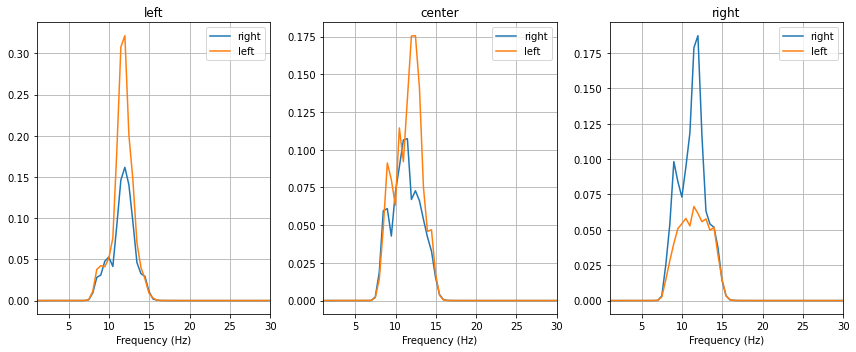

In [40]:
plot_psd(
    trials_PSD,
    freqs,
    ch_index,
     #[0, 1, 2],
    chan_lab=['left', 'center', 'right']
)

In [14]:
import scipy.signal 

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])
    # Applying the filter to each trial
    ntrials = trials.shape[0]
    trials_filt = np.zeros((ntrials, nchannels, nsamples))
    for i in range(ntrials):
        trials_filt[i,:,:] = scipy.signal.filtfilt(a, b, trials[i,:,:], axis=1)
    
    return trials_filt

In [15]:
# Apply the function
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

In [35]:
trials_filt

{'right': array([[[ 1.18900781e+00,  9.54645016e+00,  1.57385247e+01, ...,
           9.50342077e+00,  5.76216580e+00,  8.78683327e-01],
         [ 3.62110475e-01,  6.70024507e+00,  1.16187745e+01, ...,
           1.10551205e+01,  7.44337309e+00,  2.16213167e+00],
         [ 6.32869234e-01,  4.03830272e+00,  6.62959470e+00, ...,
           1.21471421e+01,  8.22851121e+00,  2.70331970e+00],
         ...,
         [ 1.93354077e-01, -1.33831124e+00, -2.74476969e+00, ...,
           1.60571161e+01,  1.11688123e+01,  4.13467291e+00],
         [ 8.87425644e-01, -6.40096018e+00, -1.24993898e+01, ...,
           1.88146549e+00,  1.21101290e+00,  2.79380209e-01],
         [ 2.80058211e-01, -6.23154388e+00, -1.15597445e+01, ...,
           1.44429728e+01,  1.09349937e+01,  5.19620984e+00]],
 
        [[-4.31326722e-02, -3.01732768e+00, -5.91085250e+00, ...,
          -4.91396339e+00, -4.65009801e+00, -3.58578741e+00],
         [-1.75644578e-01, -8.41211961e+00, -1.53525896e+01, ...,
          -3

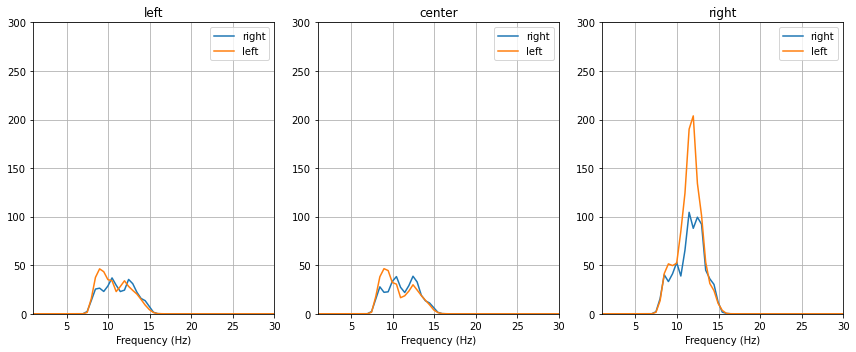

In [16]:
psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    ch_index,
    #[0, 1, 2],
    chan_lab=['left', 'center', 'right'],
    maxy=300
)

In [17]:
# Calculate the log(var) of the trials
def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=2))

In [18]:
# Apply the function
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}

In [19]:
def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=0)
    y1 = np.mean(trials[cl2], axis=0)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

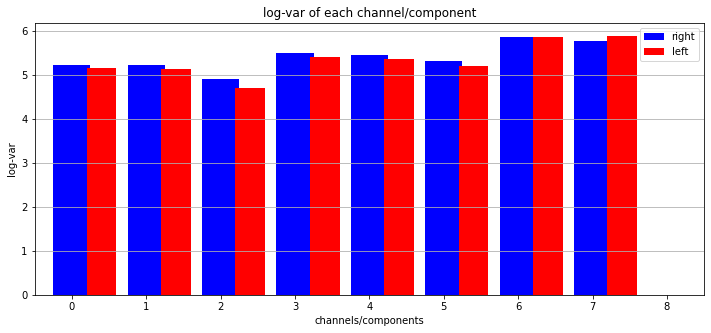

In [20]:
cl_lab=[cl1, cl2]
plot_logvar(trials_logvar)

In [21]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[0]
    covs = [ trials[i,:,:].dot(trials[i,:,:].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[0]
    trials_csp = np.zeros((ntrials, nchannels, nsamples))
    for i in range(ntrials):
        trials_csp[i,:,:] = W.T.dot(trials[i,:,:])
    return trials_csp

In [22]:
# Apply the functions
W = csp(trials_filt[cl1], trials_filt[cl2])

trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

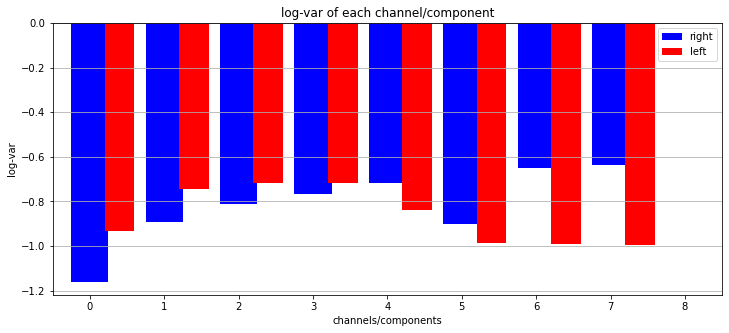

In [23]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

In [39]:
len(freqs)

161

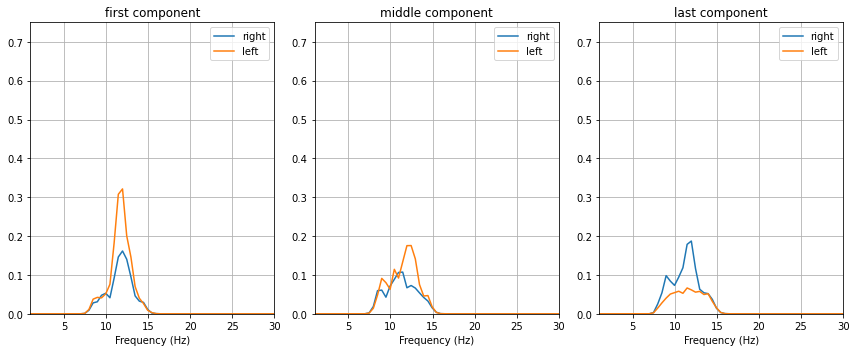

In [24]:
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

#plot_psd(trials_PSD, freqs, [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75 )
plot_psd(trials_PSD, freqs, ch_index, chan_lab=['first component', 'middle component', 'last component'], maxy=0.75 )

In [25]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[:,0], left[:,-1], color='b')
    plt.scatter(foot[:,0], foot[:,-1], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

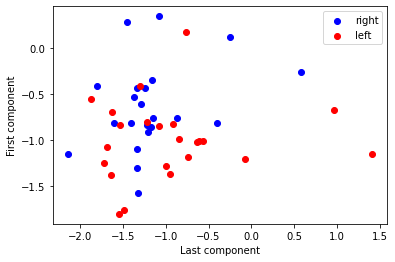

In [26]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [27]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.5 

# Calculate the number of trials for each class the above percentage boils down to
ntrain_r = int(trials_filt[cl1].shape[0] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[0] * train_percentage)
ntest_r = trials_filt[cl1].shape[0] - ntrain_r
ntest_f = trials_filt[cl2].shape[0] - ntrain_f


# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:ntrain_r,:,:],
         cl2: trials_filt[cl2][:ntrain_f,:,:]}

test = {cl1: trials_filt[cl1][ntrain_r:,:,:],
        cl2: trials_filt[cl2][ntrain_f:,:,:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

In [28]:
# Select only the first and last components for classification
comp = np.array([0,-1])
train[cl1] = train[cl1][:,comp,:]
train[cl2] = train[cl2][:,comp,:]
test[cl1] = test[cl1][:,comp,:]
test[cl2] = test[cl2][:,comp,:]

In [29]:
# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [30]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [31]:
W,b = train_lda(train[cl1], train[cl2])

print('W:', W)
print('b:', b)

W: [ 1.42606708 -2.35860894]
b: 0.2536750768747107


(-2.2, 1.0)

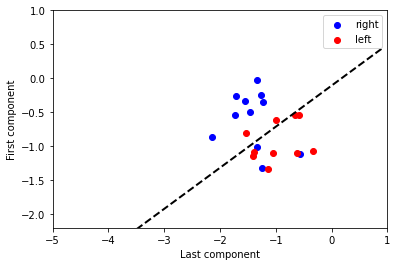

In [32]:
# Scatterplot like before
plot_scatter(train[cl1], train[cl2])
#title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

(-2.2, 1.0)

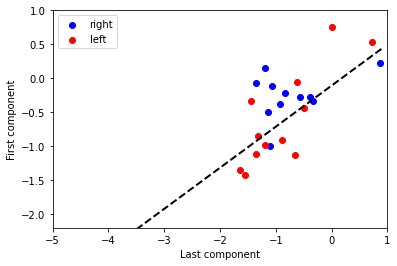

In [33]:
plot_scatter(test[cl1], test[cl2])
#title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

In [34]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(test[cl1].T, W, b) == 1).sum(), (apply_lda(test[cl2].T, W, b) == 1).sum()],
    [(apply_lda(test[cl1].T, W, b) == 2).sum(), (apply_lda(test[cl2].T, W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[8 5]
 [3 7]]

Accuracy: 0.652
